In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import warnings
# 抑制警告
warnings.filterwarnings("ignore")

In [10]:
# 读取 tissue_positions.parquet
position_df = pd.read_parquet('./Visium_HD_Mouse_Brain_binned_outputs/binned_outputs/square_008um/spatial/tissue_positions.parquet')
position_df.head

# 保存
position_df.to_csv('./Visium_HD_Mouse_Brain_binned_outputs/binned_outputs/square_008um/spatial/tissue_positions_list.csv', index=False, header=None)


In [17]:
import os
import scanpy as sc

# 设置文件路径
file_path = "./Visium_HD_Mouse_Brain_binned_outputs/binned_outputs/square_008um"
expression_file = os.path.join(file_path, "filtered_feature_bc_matrix.h5")
spatial_file = os.path.join(file_path, "spatial", "tissue_positions_list.csv")

# 加载10x Visium数据
adata = sc.read_10x_h5(expression_file)

# 加载空间坐标
import pandas as pd

coords = pd.read_csv(spatial_file, header=None)
coords.columns = ["barcode", "in_tissue", "array_row", "array_col", "pxl_row", "pxl_col"]

# 确保条目匹配
coords = coords[coords["barcode"].isin(adata.obs.index)]

# 再次检查是否一致
assert len(coords) == len(adata.obs), "条目数量仍然不一致，请检查数据"

# 将空间坐标加入到adata
adata.obs["xcoord"] = coords.set_index("barcode").loc[adata.obs.index, "array_row"].values
adata.obs["ycoord"] = coords.set_index("barcode").loc[adata.obs.index, "array_col"].values
adata.obs["coord_xy"] = list(zip(adata.obs["xcoord"], adata.obs["ycoord"]))

In [20]:
# 使基因名唯一
adata.var_names_make_unique()

# 标记线粒体基因
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# 计算质量控制指标
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], log1p=True, inplace=True)

# 过滤细胞
from banksy_utils.filter_utils import filter_cells
adata = filter_cells(adata, min_count=40, max_count=1000, MT_filter=20, gene_filter=10)

# 归一化数据
from banksy_utils.filter_utils import normalize_total
adata = normalize_total(adata)

# 筛选高变基因
from banksy_utils.filter_utils import filter_hvg
adata, adata_allgenes = filter_hvg(adata, n_top_genes=2000, flavor="seurat")

Cells before filtering: 373290

Cells after count filter: 13430

cells after MT filter: 13430

Genes after minimum cells per gene filter: 1101

--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 50.842105865478516, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 42.820072174072266, Min: 0.0

--- Normalized and log-transformed data -----
Displaying max and min of Dataset
Max: 3.7800920009613037, Min: 0.0

Displaying dataset after filtering by HVG
View of AnnData object with n_obs × n_vars = 13430 × 1101
    obs: 'xcoord', 'ycoord', 'coord_xy', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_co

In [22]:
# 保存到 .h5ad 文件
output_dir = "./data/visium_hd_processed"  # 替换为你想要的输出目录路径
os.makedirs(output_dir, exist_ok=True)  # 如果目录不存在，则创建
output_file = os.path.join(output_dir, "visium_preprocessed.h5ad")

adata.write(output_file)

print(f"数据已保存到: {output_file}")

TypeError: Can't implicitly convert non-string objects to strings

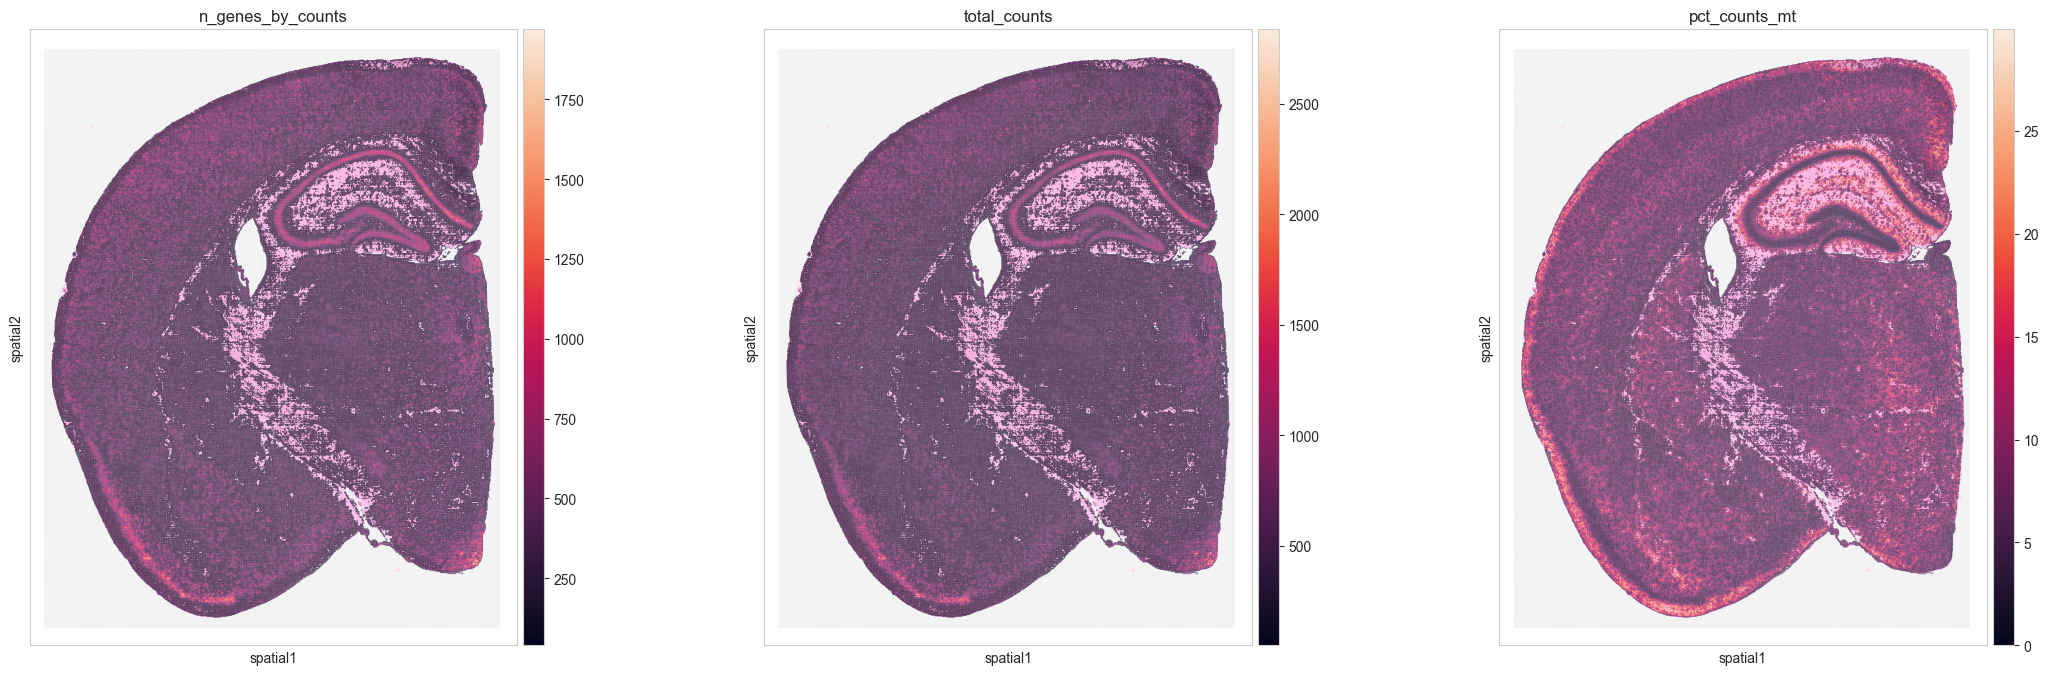

In [14]:
# 细胞过滤后，空间上展示展示基因数、counts, 线粒体比例数等
with rc_context({'figure.figsize': (8, 8)}):
    sc.pl.spatial(
        adata, 
        color=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
        library_id='MouseBrain',
        alpha_img=0.6
    )

ValueError: Length of values (702244) does not match length of index (393543)